# Mô hình hóa Rủi ro Riêng lẻ (Marginal Risk Modeling)

Notebook này thực hiện các bước mô hình hóa rủi ro riêng lẻ cho từng cổ phiếu, bao gồm:
- Fit mô hình GARCH(1,1) với phân phối Student's t để mô hình hóa biến động.
- Kiểm tra chẩn đoán phần dư chuẩn hóa từ mô hình GARCH.
- Mô hình hóa rủi ro cực đoan (EVT) cho phần đuôi của phần dư chuẩn hóa.

## 1. Import thư viện và các hàm mô hình hóa

Import các thư viện cần thiết và các hàm đã xây dựng trong module `modeling.py`.

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import pickle
sys.path.append('../src')
from marginal_garch_evt import fit_arima_egarch, calc_conditional_pit, diagnostic_residuals, fit_evt_two_tails

## 2. Đọc dữ liệu log returns và chuẩn hóa tỷ lệ

Đọc dữ liệu log returns đã xử lý từ bước EDA.  
Để phù hợp với thông lệ tài chính, log returns được nhân với 100 (chuyển sang đơn vị phần trăm).

In [2]:
log_returns = pd.read_csv("../data/processed/log_returns.csv", index_col=0)
print("Loaded log_returns shape:", log_returns.shape)

 # Scale log returns (nếu muốn)
log_returns_scaled = log_returns * 100

Loaded log_returns shape: (2776, 5)


In [20]:
# --- Grid search ARIMA + GARCH/GJR/EGARCH + t/ged/skewt cho từng mã cổ phiếu ---
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

def ljungbox_p(resid, lag=10):
    return acorr_ljungbox(resid, lags=[lag], return_df=True)['lb_pvalue'].iloc[0]

def try_arima_gjr_egarch(y, p_list=(0,1,2), q_list=(0,1), d=0,
                         vol_list=('GARCH','EGARCH','GARCH'), # GJR=GARCH o=1; EGARCH; GARCH chuẩn
                         asym_o=(1,0,0),
                         dist_list=('t','ged','skewt'),
                         lag_lb=10):
    best = None
    y = y.dropna()
    for p in p_list:
        for q in q_list:
            arima = SARIMAX(y, order=(p,d,q), trend='c').fit(disp=False)
            resid_mean = arima.resid.dropna()
            for vol, o in zip(vol_list, asym_o):
                for dist in dist_list:
                    try:
                        am = arch_model(resid_mean, mean='Zero', vol=vol, p=1, o=o, q=1, dist=dist)
                        res = am.fit(disp='off', update_freq=0, show_warning=False)
                        stdr = res.std_resid.dropna()
                        # Tính PIT và p-value Ljung-Box trên PIT
                        pit = pit_from_arch_dist(stdr, dist, res.params)
                        pval_pit = ljungbox_p(pit, lag=lag_lb)
                        aic = res.aic
                        cand = {'p':p, 'q':q, 'vol':vol, 'o':o, 'dist':dist,
                                'pval_pit':float(pval_pit), 'aic':float(aic),
                                'model':res, 'arima':arima}
                        if best is None:
                            best = cand
                        else:
                            def score(c):
                                ok = (c['pval_pit'] >= 0.05)
                                # Ưu tiên PIT-pvalue lớn nhất, tie-break AIC nhỏ nhất
                                return (ok, c['pval_pit'], -c['aic'])
                            if score(cand) > score(best):
                                best = cand
                    except Exception as e:
                        continue
    return best

# Hàm tính PIT nhất quán theo arch
from arch.univariate.distribution import StudentsT, GeneralizedError, SkewStudent
def pit_from_arch_dist(stdresid, dist_name, params):
    x = np.asarray(stdresid, float)
    if dist_name == 't':
        dist = StudentsT()
        par = [float(params['nu'])]
    elif dist_name == 'ged':
        dist = GeneralizedError()
        par = [float(params['nu'])]
    elif dist_name == 'skewt':
        dist = SkewStudent()
        nu = float(params.get('eta', params.get('nu')))
        lam = float(params.get('lambda', params.get('skew')))
        par = [nu, lam]
    else:
        raise ValueError('Unsupported dist')
    return dist.cdf(x, par)

# --- Chọn ticker để chạy ---
ticker = 'FPT_DATA'  # Thay bằng mã bạn muốn, ví dụ: 'HPG_DATA', 'FPT_DATA', ...
y = log_returns_scaled[ticker]
best_model = try_arima_gjr_egarch(y)
print(f'Best {ticker}:', best_model['p'], best_model['q'], best_model['vol'], best_model['o'], best_model['dist'], best_model['pval_pit'], best_model['aic'])

# Lấy standardized residuals và tính conditional PIT nhất quán
stdr = best_model['model'].std_resid.dropna()
dist = best_model['dist']
params = best_model['model'].params
pit = pit_from_arch_dist(stdr, dist, params)

print('Ljung-Box p-value for PIT:', ljungbox_p(pit))

c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula

Best FPT_DATA: 2 1 EGARCH 0 skewt 0.9538961063706246 9740.616410548639
Ljung-Box p-value for PIT: 0.9538961063706246


In [21]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from arch import arch_model

# ============== 1) Grid-search cho MỘT series ==============
def fit_best_marginal(y, search_params=None, verbose=True):
    """
    Grid search ARIMA + {GARCH, GJR, EGARCH} + {t, ged, skewt} cho 1 series.
    Trả về: dict {'p','d','q','vol','o','dist','pval_pit','aic','model','arima','pit','std_resid'}
    """
    # ---- helpers nội bộ (để chỉ cần 2 hàm public) ----
    def ljungbox_p(x, lag=10):
        x = pd.Series(x).dropna()
        return float(acorr_ljungbox(x, lags=[lag], return_df=True)['lb_pvalue'].iloc[0])

    # PIT dùng đúng phân phối của arch (tránh sai tham số hóa)
    from arch.univariate.distribution import StudentsT, GeneralizedError, SkewStudent
    def pit_from_arch_dist(stdresid, dist_name, params):
        x = np.asarray(pd.Series(stdresid).dropna(), float)
        if dist_name == 't':
            dist = StudentsT();  par = [float(params['nu'])]
        elif dist_name == 'ged':
            dist = GeneralizedError();  par = [float(params['nu'])]
        elif dist_name == 'skewt':
            dist = SkewStudent()
            nu = float(params.get('eta', params.get('nu')))
            lam = float(params.get('lambda', params.get('skew')))
            par = [nu, lam]
        else:
            raise ValueError('Unsupported dist')
        return dist.cdf(x, par)

    # ---- tham số mặc định ----
    defaults = dict(
        p_list=(0,1,2),
        q_list=(0,1),
        d_list=(1,0),           # ưu tiên d=1, sau đó thử d=0
        vol_list=('GARCH','EGARCH','GARCH'),  # GJR=GARCH với o=1
        asym_o=(1,0,0),         # o=1 cho GJR; 0 cho EGARCH & GARCH
        dist_list=('t','ged','skewt'),
        lag_lb=10,
        min_obs=150             # bỏ qua nếu residual quá ngắn
    )
    P = {**defaults, **(search_params or {})}

    y = pd.Series(y).dropna()
    best = None

    for d in P['d_list']:
        for p in P['p_list']:
            for q in P['q_list']:
                # 1) Ước lượng mean bằng ARIMA
                try:
                    arima = SARIMAX(
                        y, order=(p,d,q), trend='c',
                        enforce_stationarity=False, enforce_invertibility=False
                    ).fit(disp=False)
                except Exception as e:
                    if verbose: print(f"[ARIMA({p},{d},{q})] fail: {e}")
                    continue

                resid_mean = pd.Series(arima.resid).dropna()
                if resid_mean.size < P['min_obs']:
                    continue

                # 2) Volatility: GARCH / GJR(o=1) / EGARCH
                for vol, o in zip(P['vol_list'], P['asym_o']):
                    for dist in P['dist_list']:
                        try:
                            am = arch_model(resid_mean, mean='Zero', vol=vol, p=1, o=o, q=1, dist=dist)
                            res = am.fit(disp='off', update_freq=0, show_warning=False)
                            stdr = pd.Series(res.std_resid).dropna()

                            # 3) PIT đúng phân phối
                            pit = pit_from_arch_dist(stdr, dist, res.params)

                            # 4) chấm điểm theo Ljung-Box trên PIT (+ tie-break AIC)
                            pval_pit = ljungbox_p(pit, lag=P['lag_lb'])
                            aic = float(res.aic)

                            cand = {
                                'p':p, 'd':d, 'q':q, 'vol':vol, 'o':o, 'dist':dist,
                                'pval_pit': float(pval_pit), 'aic': aic,
                                'model': res, 'arima': arima,
                                'pit': pit, 'std_resid': stdr
                            }

                            if best is None:
                                best = cand
                            else:
                                # Ưu tiên p-value PIT lớn hơn; nếu gần bằng thì AIC nhỏ hơn
                                if (cand['pval_pit'] > best['pval_pit']) or \
                                   (np.isclose(cand['pval_pit'], best['pval_pit']) and cand['aic'] < best['aic']):
                                    best = cand
                        except Exception as e:
                            if verbose: print(f"[{vol}-{dist}] fail: {e}")
                            continue
    return best


# ============== 2) Chạy cho TOÀN BỘ DataFrame ==============
def grid_search_marginal_model(log_returns_scaled, search_params=None, verbose=True):
    """
    Chạy fit_best_marginal cho từng cột trong DataFrame.
    Trả về:
      - summary_df: DataFrame (Ticker, p,d,q,vol,o,dist,pval_pit,aic)
      - models: dict {Ticker: dict_best} chứa cả model, arima, pit, std_resid
    """
    rows = []
    models = {}

    for ticker in log_returns_scaled.columns:
        best = fit_best_marginal(log_returns_scaled[ticker], search_params, verbose)
        if best is None:
            if verbose: print(f"[{ticker}] No model converged.")
            continue
        row = {
            'Ticker': ticker,
            'p': best['p'], 'd': best['d'], 'q': best['q'],
            'vol': best['vol'], 'o': best['o'], 'dist': best['dist'],
            'pval_pit': best['pval_pit'], 'aic': best['aic']
        }
        rows.append(row)
        models[ticker] = best

    summary_df = pd.DataFrame(rows).sort_values(['pval_pit', 'aic'], ascending=[False, True]).reset_index(drop=True)
    return summary_df, models


In [22]:
summary_df, models = grid_search_marginal_model(log_returns_scaled)
print(summary_df)

c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula

     Ticker  p  d  q     vol  o   dist  pval_pit           aic
0  FPT_DATA  2  0  1  EGARCH  0  skewt  0.954161   9741.625978
1  HPG_DATA  2  0  1   GARCH  1  skewt  0.791550  11367.046107
2  VCB_DATA  2  0  1   GARCH  0      t  0.697344  10372.244222
3  VIC_DATA  2  1  1   GARCH  1    ged  0.510886  10169.527897
4  MWG_DATA  2  0  1  EGARCH  0  skewt  0.342848  11480.377754


In [13]:
# --- Kiểm tra kết quả grid_search_marginal_model cho một ticker bất kỳ ---
summary_df = grid_search_marginal_model(log_returns_scaled)
ticker = 'MWG_DATA'  # Thay bằng mã bạn muốn kiểm tra

# Kiểm tra cột Ticker có tồn tại không
if 'Ticker' in summary_df.columns:
    row = summary_df[summary_df['Ticker'] == ticker].iloc[0]
elif summary_df.index.name == 'Ticker' or ticker in summary_df.index:
    row = summary_df.loc[ticker]
else:
    print('summary_df columns:', summary_df.columns)
    print('summary_df index:', summary_df.index)
    print('summary_df head:')
    print(summary_df.head())
    raise KeyError('Không tìm thấy ticker trong DataFrame. Kiểm tra lại output của grid_search_marginal_model.')

model = row['model']
arima = row['arima']
stdr = model.std_resid.dropna()
dist = row['dist']
params = model.params
pit = pit_from_arch_dist(stdr, dist, params)

print(f"Best model for {ticker}: p={row['p']}, q={row['q']}, vol={row['vol']}, o={row['o']}, dist={row['dist']}, pval_pit={row['pval_pit']:.4f}, aic={row['aic']:.2f}")

print('Ljung-Box p-value cho PIT ở các lags:')
for L in [5, 10, 20]:
    pval = ljungbox_p(pit, lag=L)
    print(f'lag={L}: p-value={pval:.4f}')

from scipy.stats import kstest
print('\nKS test cho PIT so với Uniform(0,1):')
ks_stat, ks_p = kstest(pit, 'uniform')
print(f'KS statistic={ks_stat:.4f}, p-value={ks_p:.4f}')

from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(stdr, lags=20, ax=axes[0], zero=False)
axes[0].set_title(f'ACF of Std. Residuals ({ticker})')
axes[0].grid(True, linestyle='--', alpha=0.5)
plot_acf(stdr**2, lags=20, ax=axes[1], zero=False)
axes[1].set_title(f'ACF of Squared Std. Residuals ({ticker})')
axes[1].grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula

summary_df columns: RangeIndex(start=0, stop=0, step=1)
summary_df index: RangeIndex(start=0, stop=0, step=1)
summary_df head:
Empty DataFrame
Columns: []
Index: []


KeyError: 'Không tìm thấy ticker trong DataFrame. Kiểm tra lại output của grid_search_marginal_model.'

## 3. Fit mô hình GARCH(1,1) với Student's t cho từng cổ phiếu

Tiến hành fit mô hình GARCH(1,1) với phân phối Student's t cho từng chuỗi lợi suất.  
Kết quả trả về gồm:
- Đối tượng kết quả mô hình GARCH cho từng mã.
- Chuỗi phần dư chuẩn hóa (standardized residuals) cho từng mã.

In [3]:
# Fit ARIMA(2,1,0) + EGARCH(1,1) + skew-t cho tất cả mã, lấy standardized residuals và model
results = fit_arima_egarch(log_returns_scaled)
std_resids = {ticker: v['std_resid'] for ticker, v in results.items()}
garch_results = {ticker: v['egarch'] for ticker, v in results.items()}

# Convert std_resids (dict) to DataFrame and save
std_resids_df = pd.DataFrame(std_resids)
std_resids_df.to_csv("../data/processed/std_resids.csv")

# Save GARCH results
with open("../data/processed/garch_results.pkl", "wb") as f:
    pickle.dump(garch_results, f)

c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula-modeling\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\OneDrive\Duong's Documents\Projects\garch-evt-copula

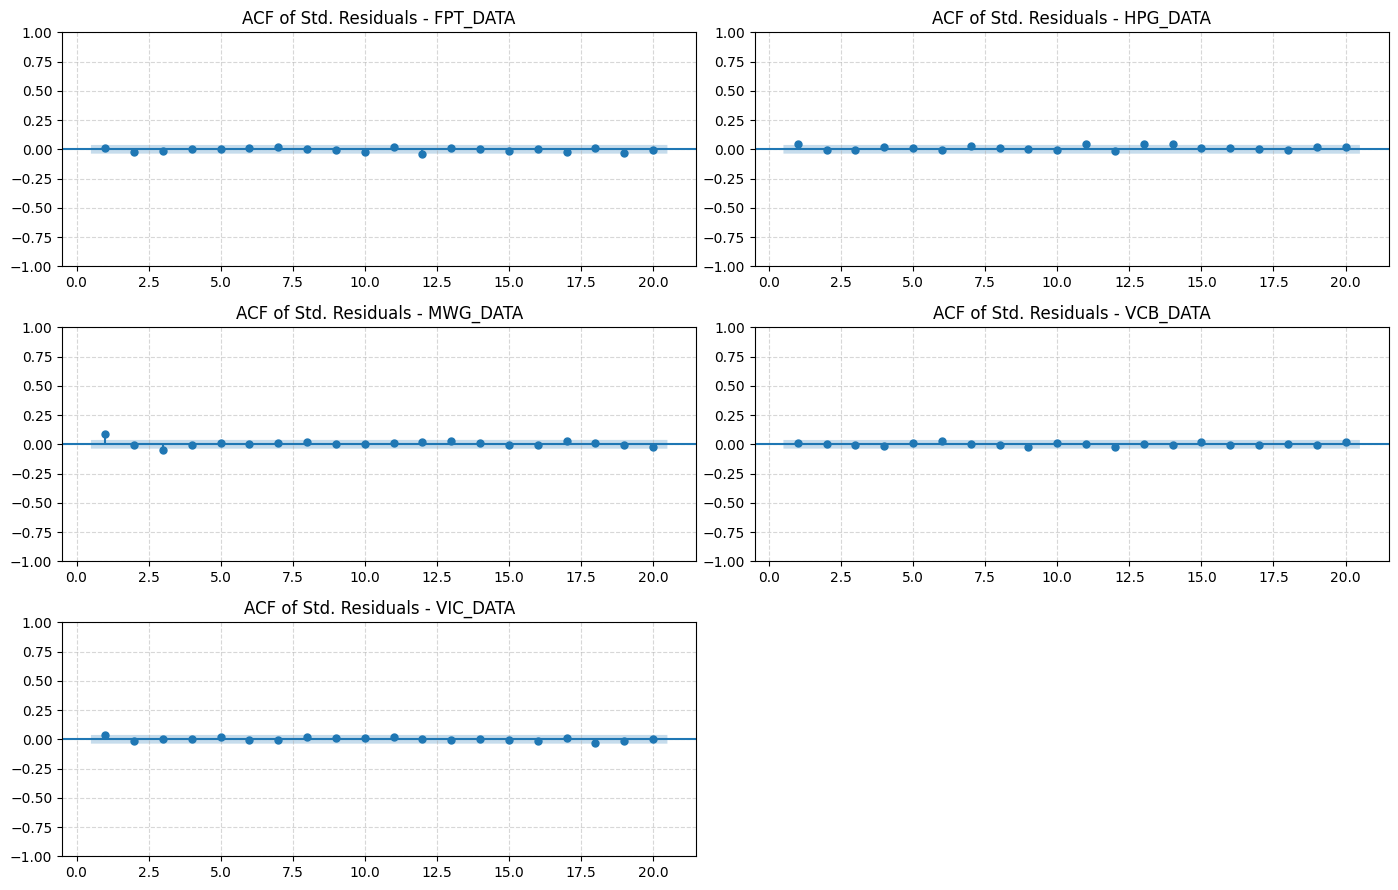

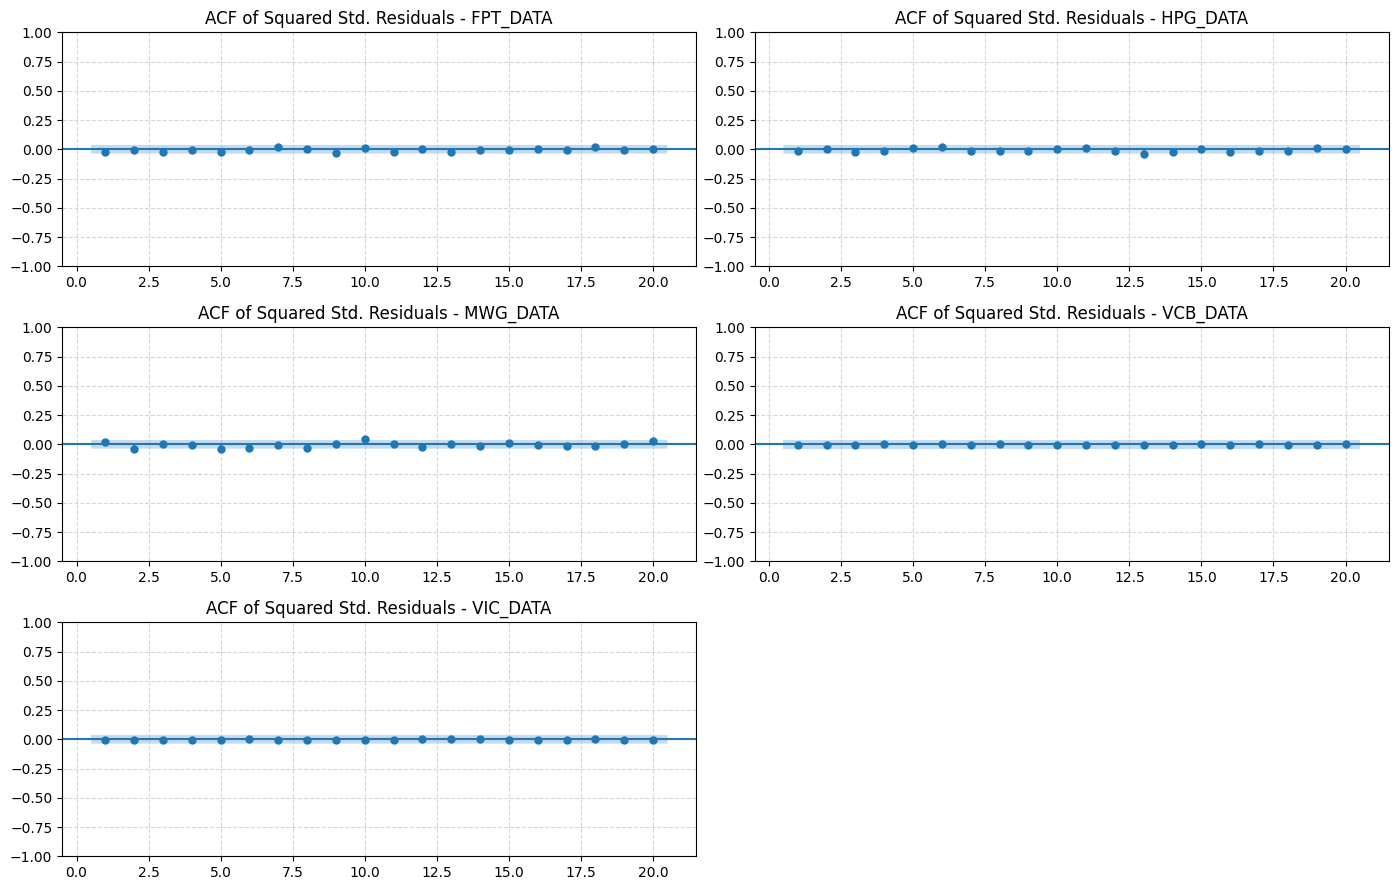

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

n = len(std_resids)
cols = 2
rows = int(np.ceil(n / cols))
fig1, axes1 = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
axes1 = axes1.flatten()

fig2, axes2 = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
axes2 = axes2.flatten()

for i, (ticker, resid) in enumerate(std_resids.items()):
    # ACF of standardized residuals
    plot_acf(resid.dropna(), lags=20, ax=axes1[i], zero=False)
    axes1[i].set_title(f"ACF of Std. Residuals - {ticker}")
    axes1[i].grid(True, linestyle='--', alpha=0.5)
    # ACF of squared standardized residuals
    plot_acf(resid.dropna()**2, lags=20, ax=axes2[i], zero=False)
    axes2[i].set_title(f"ACF of Squared Std. Residuals - {ticker}")
    axes2[i].grid(True, linestyle='--', alpha=0.5)

# Hide unused subplots
for j in range(i + 1, len(axes1)):
    axes1[j].axis('off')
    axes2[j].axis('off')

fig1.tight_layout()
fig2.tight_layout()
plt.show()

In [4]:
# Tính và lưu conditional PIT
pit_dict = calc_conditional_pit(garch_results)
with open("../data/processed/conditional_pit.pkl", "wb") as f:
    pickle.dump(pit_dict, f)
print("Saved conditional_pit.pkl")

Saved conditional_pit.pkl


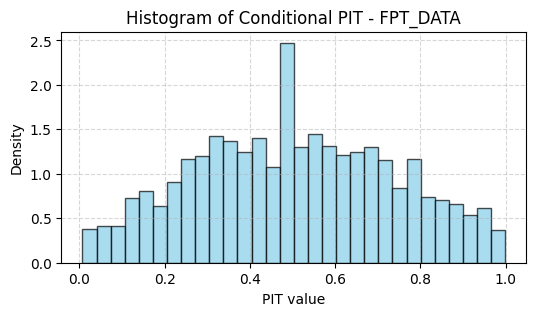

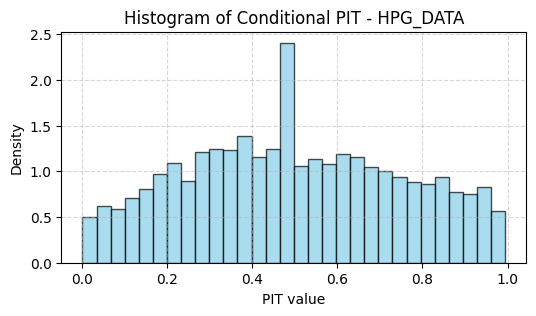

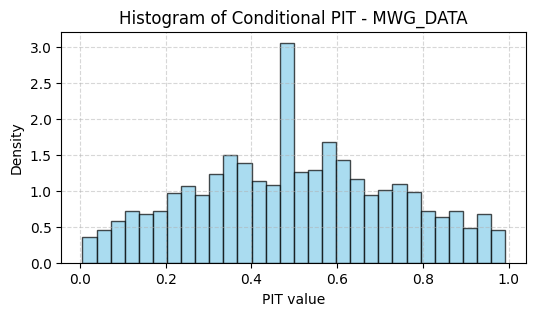

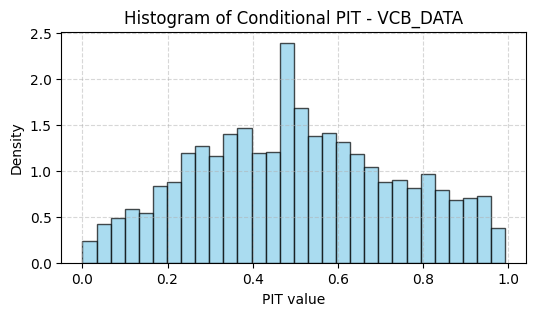

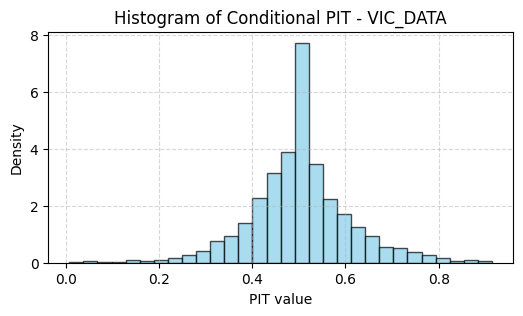

In [7]:
for ticker, pit in pit_dict.items():
    plt.figure(figsize=(6, 3))
    plt.hist(pit, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of Conditional PIT - {ticker}')
    plt.xlabel('PIT value')
    plt.ylabel('Density')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

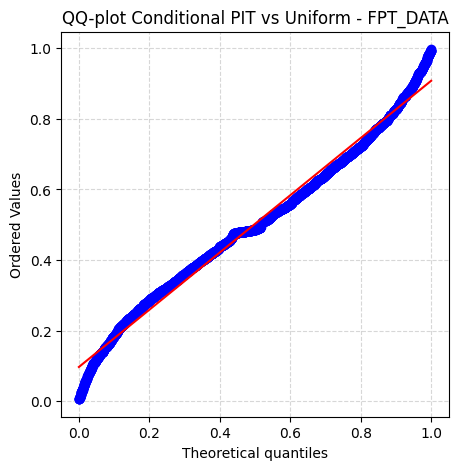

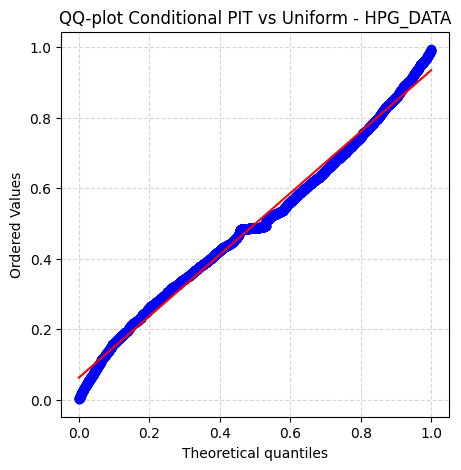

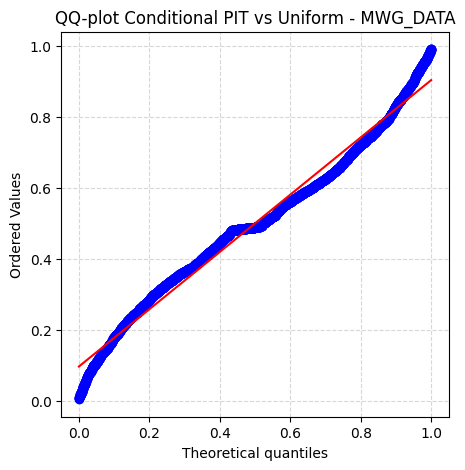

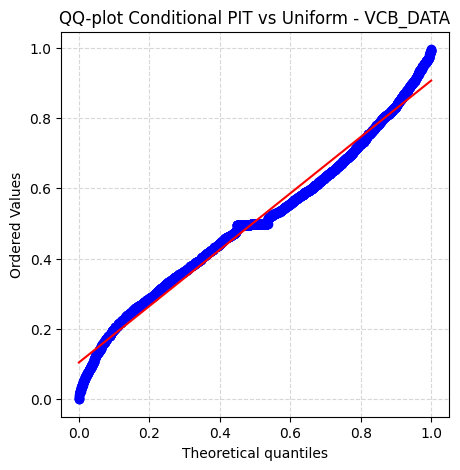

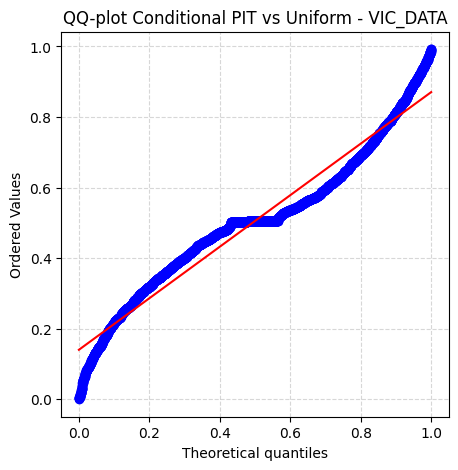

In [11]:
import numpy as np
import scipy.stats as stats

for ticker, pit in pit_dict.items():
    plt.figure(figsize=(5, 5))
    stats.probplot(pit, dist=stats.uniform, plot=plt)
    plt.title(f'QQ-plot Conditional PIT vs Uniform - {ticker}')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [5]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for ticker, pit in pit_dict.items():
    lb_pvalue = acorr_ljungbox(pit, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
    print(f"{ticker}: Ljung-Box p-value (lag 10) = {lb_pvalue:.4f}")

FPT_DATA: Ljung-Box p-value (lag 10) = 0.0000
HPG_DATA: Ljung-Box p-value (lag 10) = 0.0000
MWG_DATA: Ljung-Box p-value (lag 10) = 0.0000
VCB_DATA: Ljung-Box p-value (lag 10) = 0.0000
VIC_DATA: Ljung-Box p-value (lag 10) = 0.0000


## 4. Kiểm tra chẩn đoán phần dư chuẩn hóa

Kiểm tra chất lượng phần dư chuẩn hóa bằng các kiểm định:
- ARCH test: Kiểm tra còn hiện tượng ARCH không.
- Ljung-Box test: Kiểm tra còn tự tương quan không.
- Thực hiện trên cả phần dư và phần dư bình phương.
Kỳ vọng các p-value lớn hơn 0.05, cho thấy phần dư đã "sạch".

In [4]:
diag_results = diagnostic_residuals(std_resids, lags=10, plot=True)

FPT_DATA: ARCH p=0.598, Ljung-Box p=0.883, ARCH^2 p=0.963, Ljung-Box^2 p=0.620
HPG_DATA: ARCH p=0.811, Ljung-Box p=0.472, ARCH^2 p=0.969, Ljung-Box^2 p=0.813
MWG_DATA: ARCH p=0.056, Ljung-Box p=0.001, ARCH^2 p=0.730, Ljung-Box^2 p=0.043
VCB_DATA: ARCH p=1.000, Ljung-Box p=0.818, ARCH^2 p=1.000, Ljung-Box^2 p=1.000
VIC_DATA: ARCH p=1.000, Ljung-Box p=0.556, ARCH^2 p=1.000, Ljung-Box^2 p=1.000


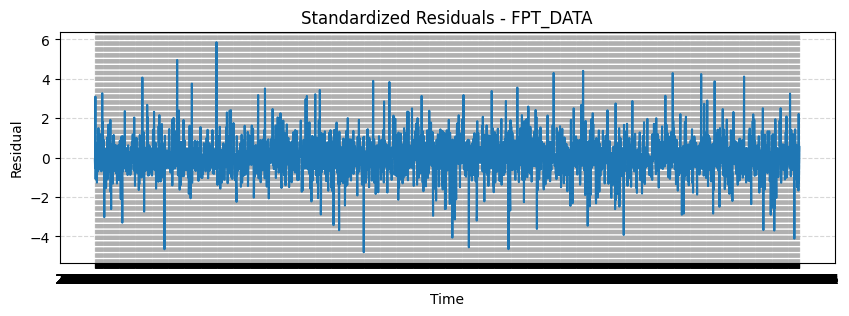

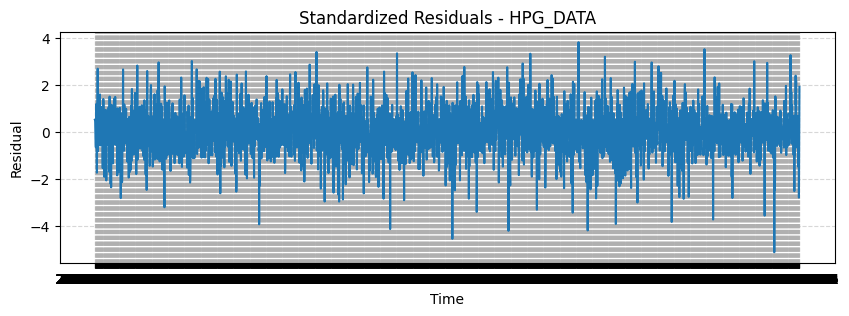

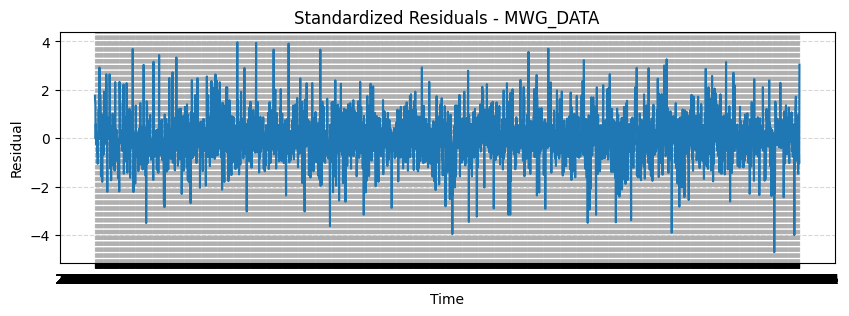

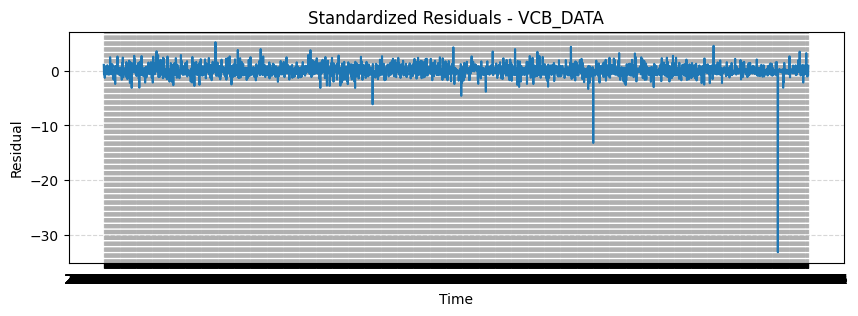

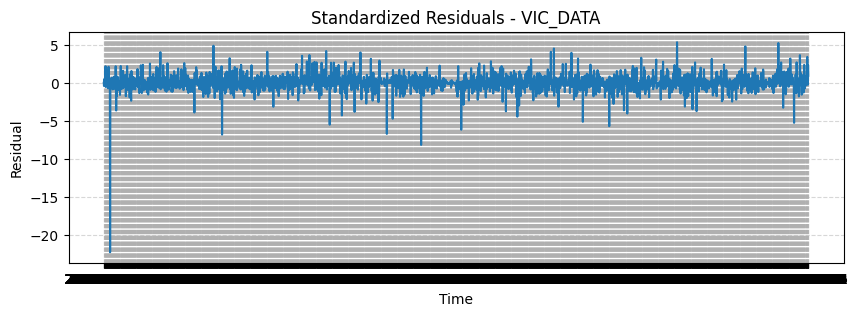

In [5]:
for ticker, resid in std_resids.items():
    plt.figure(figsize=(10, 3))
    plt.plot(resid)
    plt.title(f'Standardized Residuals - {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

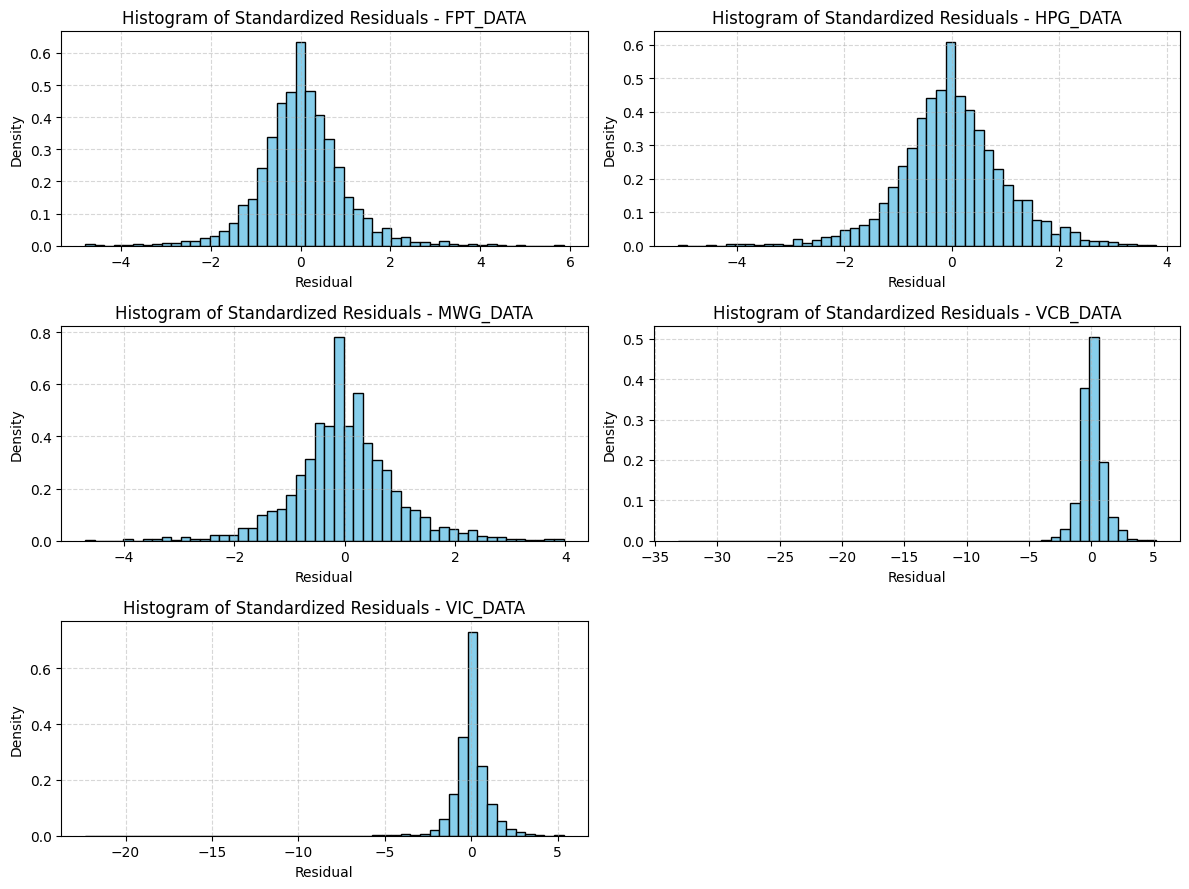

In [12]:
import math

n = len(std_resids)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids.items()):
    axes[i].hist(resid, bins=50, color='skyblue', edgecolor='black', density=True)
    axes[i].set_title(f'Histogram of Standardized Residuals - {ticker}')
    axes[i].set_xlabel('Residual')
    axes[i].set_ylabel('Density')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn các subplot thừa nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

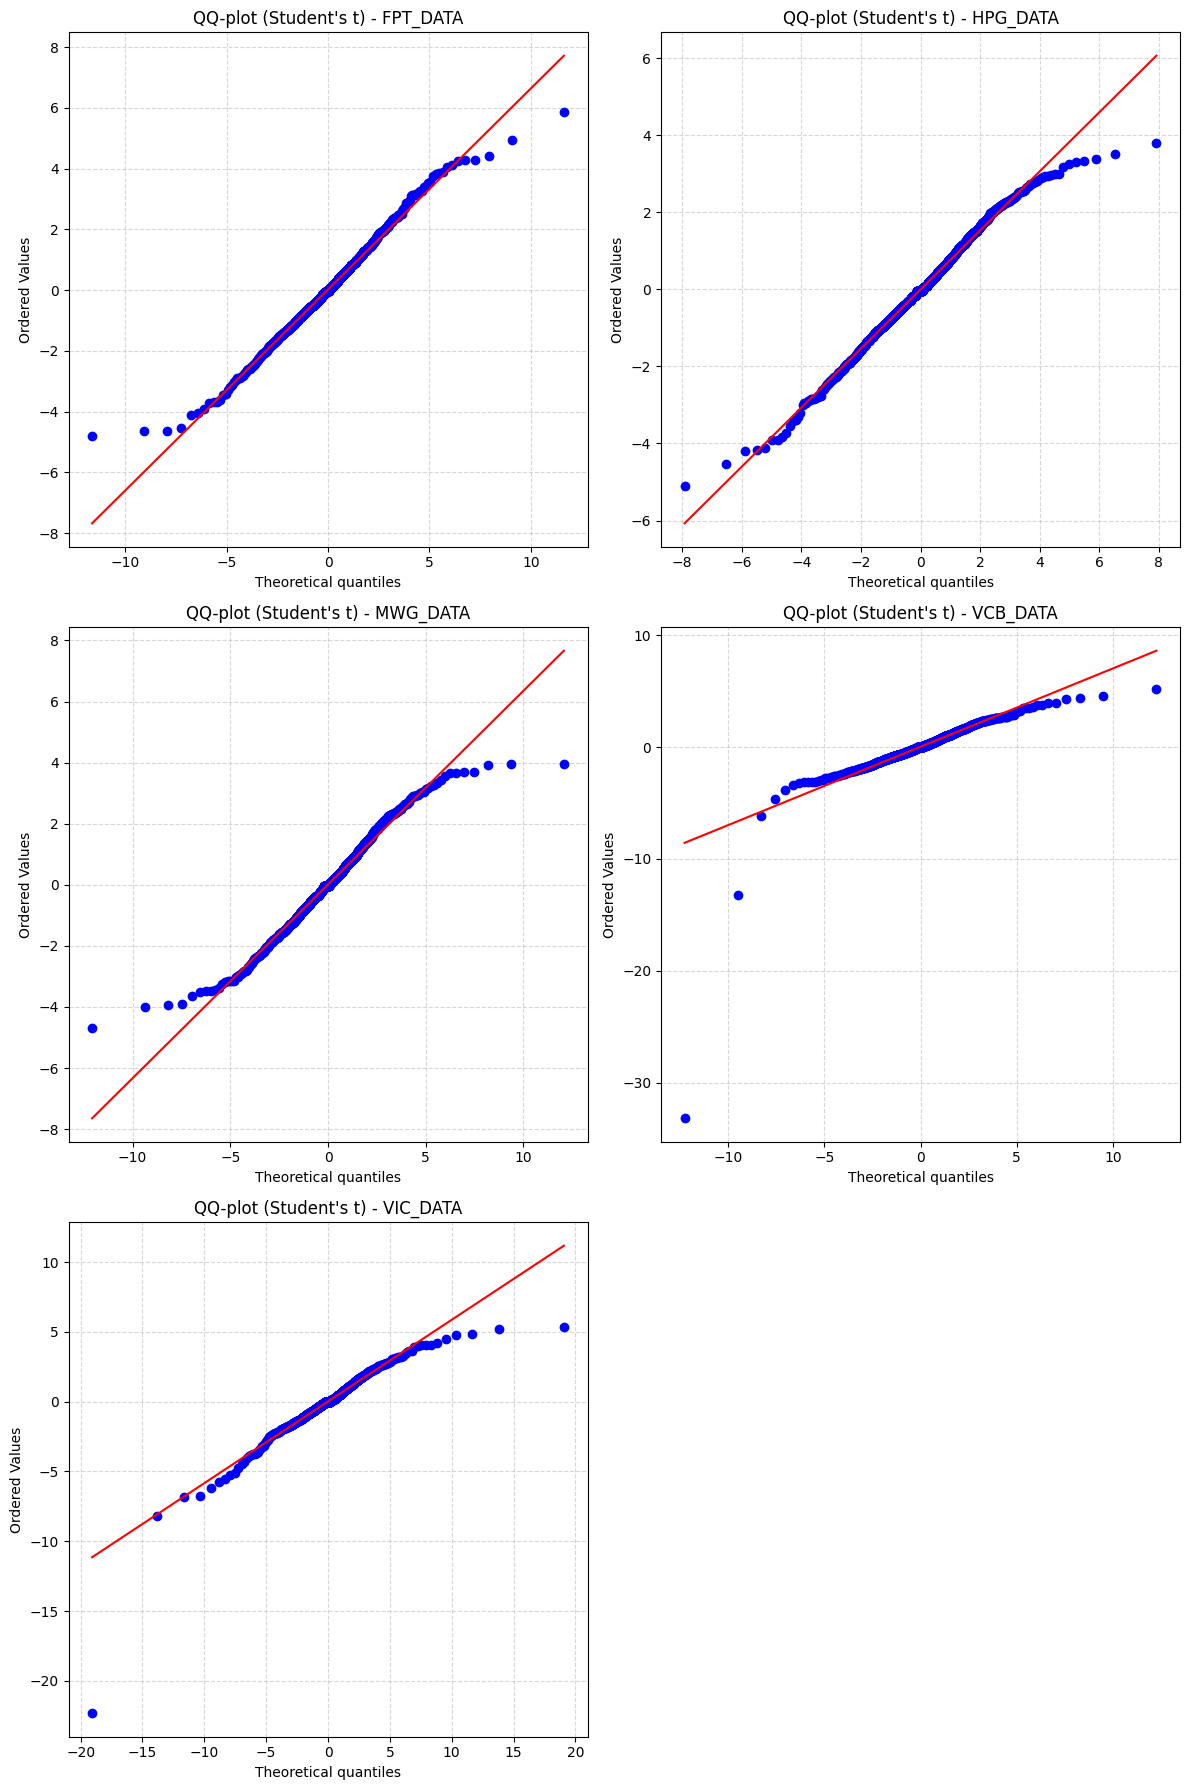

In [13]:
import math
from scipy.stats import probplot

n = len(std_resids)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids.items()):
    probplot(resid, dist="t", sparams=(garch_results[ticker].params['nu'],), plot=axes[i])
    axes[i].set_title(f"QQ-plot (Student's t) - {ticker}")
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn các subplot thừa nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 5. Mô hình hóa rủi ro cực đoan (EVT) cho phần dư chuẩn hóa

Áp dụng Extreme Value Theory (EVT) cho phần đuôi âm (lỗ lớn) của phần dư chuẩn hóa:
- Chọn ngưỡng (quantile 95%).
- Fit phân phối Pareto tổng quát (GPD) cho các giá trị vượt ngưỡng.
- Lưu lại các tham số threshold, shape, scale cho từng mã.

EVT for FPT_DATA: threshold=1.4125, shape=0.0949, scale=0.6542
EVT for HPG_DATA: threshold=1.5689, shape=-0.0059, scale=0.6854
EVT for MWG_DATA: threshold=1.4867, shape=0.0167, scale=0.6364
EVT for VCB_DATA: threshold=1.3493, shape=0.3088, scale=0.5721
EVT for VIC_DATA: threshold=1.3629, shape=0.5190, scale=0.5228


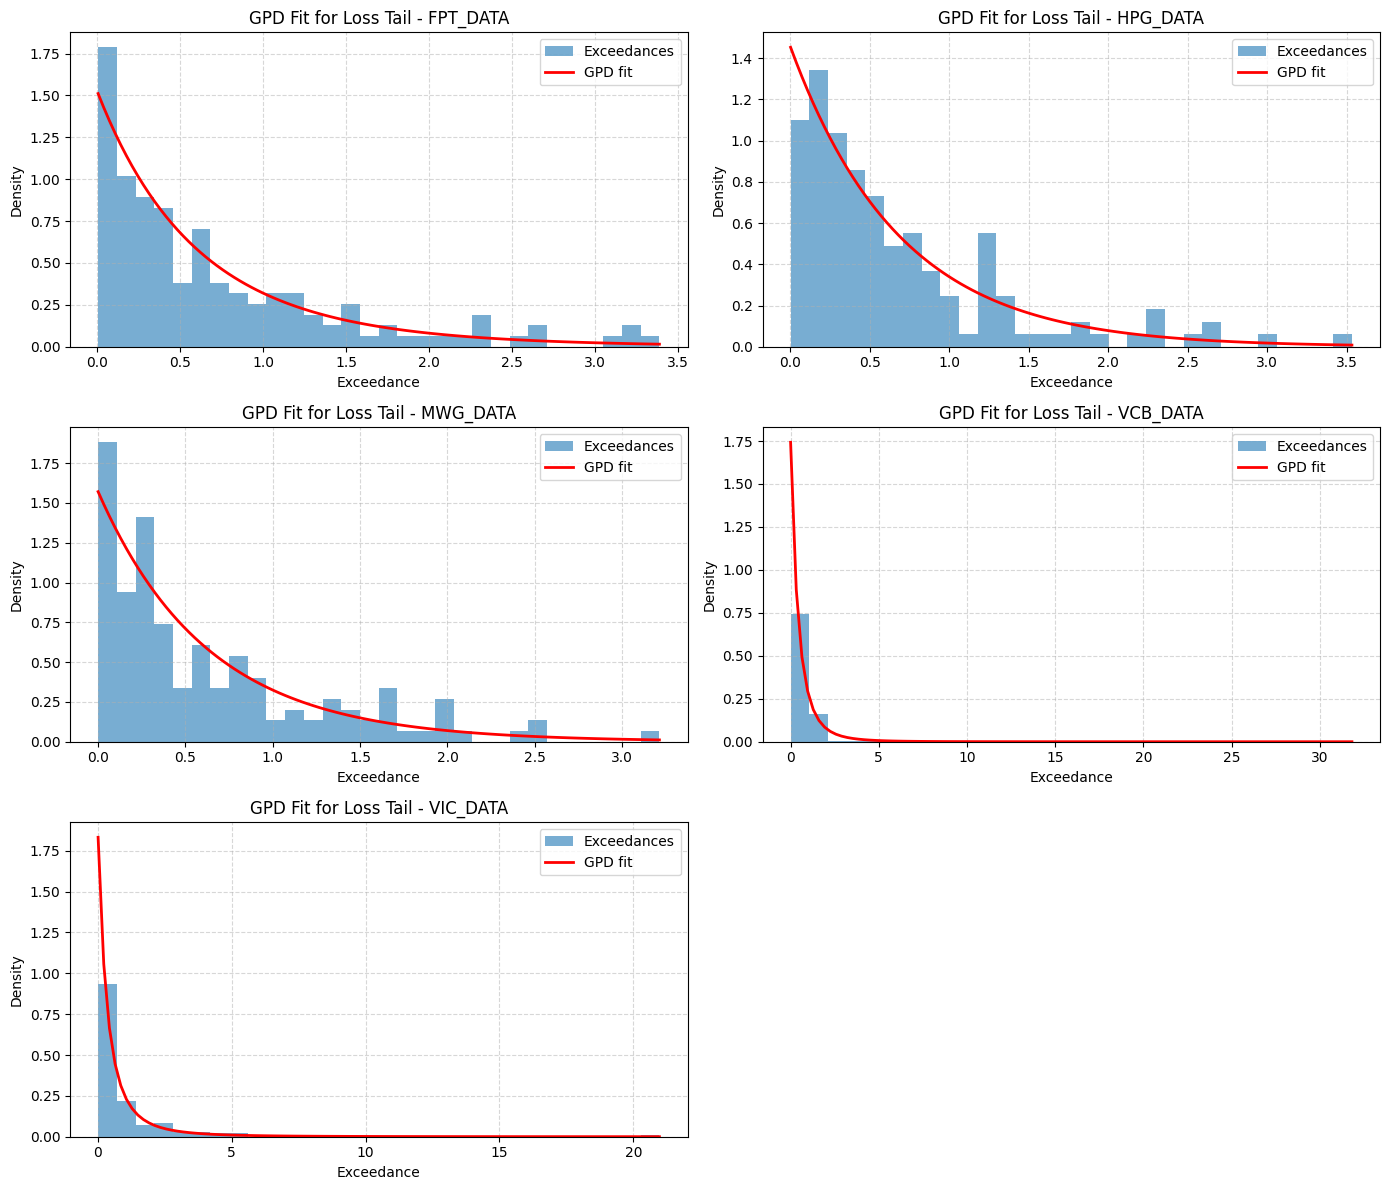

In [ ]:
evt_results = fit_evt_two_tails(std_resids, quantile=0.95)

# Save EVT results (dict) as pickle
with open("../data/processed/evt_results.pkl", "wb") as f:
    pickle.dump(evt_results, f)

n = len(std_resids)
cols = 2
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 4), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids.items()):
    losses = -resid.dropna()
    threshold = evt_results[ticker]['threshold']
    exceedances = losses[losses > threshold] - threshold
    shape = evt_results[ticker]['shape']
    scale = evt_results[ticker]['scale']
    axes[i].hist(exceedances, bins=30, density=True, alpha=0.6, label='Exceedances')
    x = np.linspace(exceedances.min(), exceedances.max(), 100)
    axes[i].plot(x, genpareto.pdf(x, shape, loc=0, scale=scale), 'r-', lw=2, label='GPD fit')
    axes[i].set_title(f'GPD Fit for Loss Tail - {ticker}')
    axes[i].set_xlabel('Exceedance')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

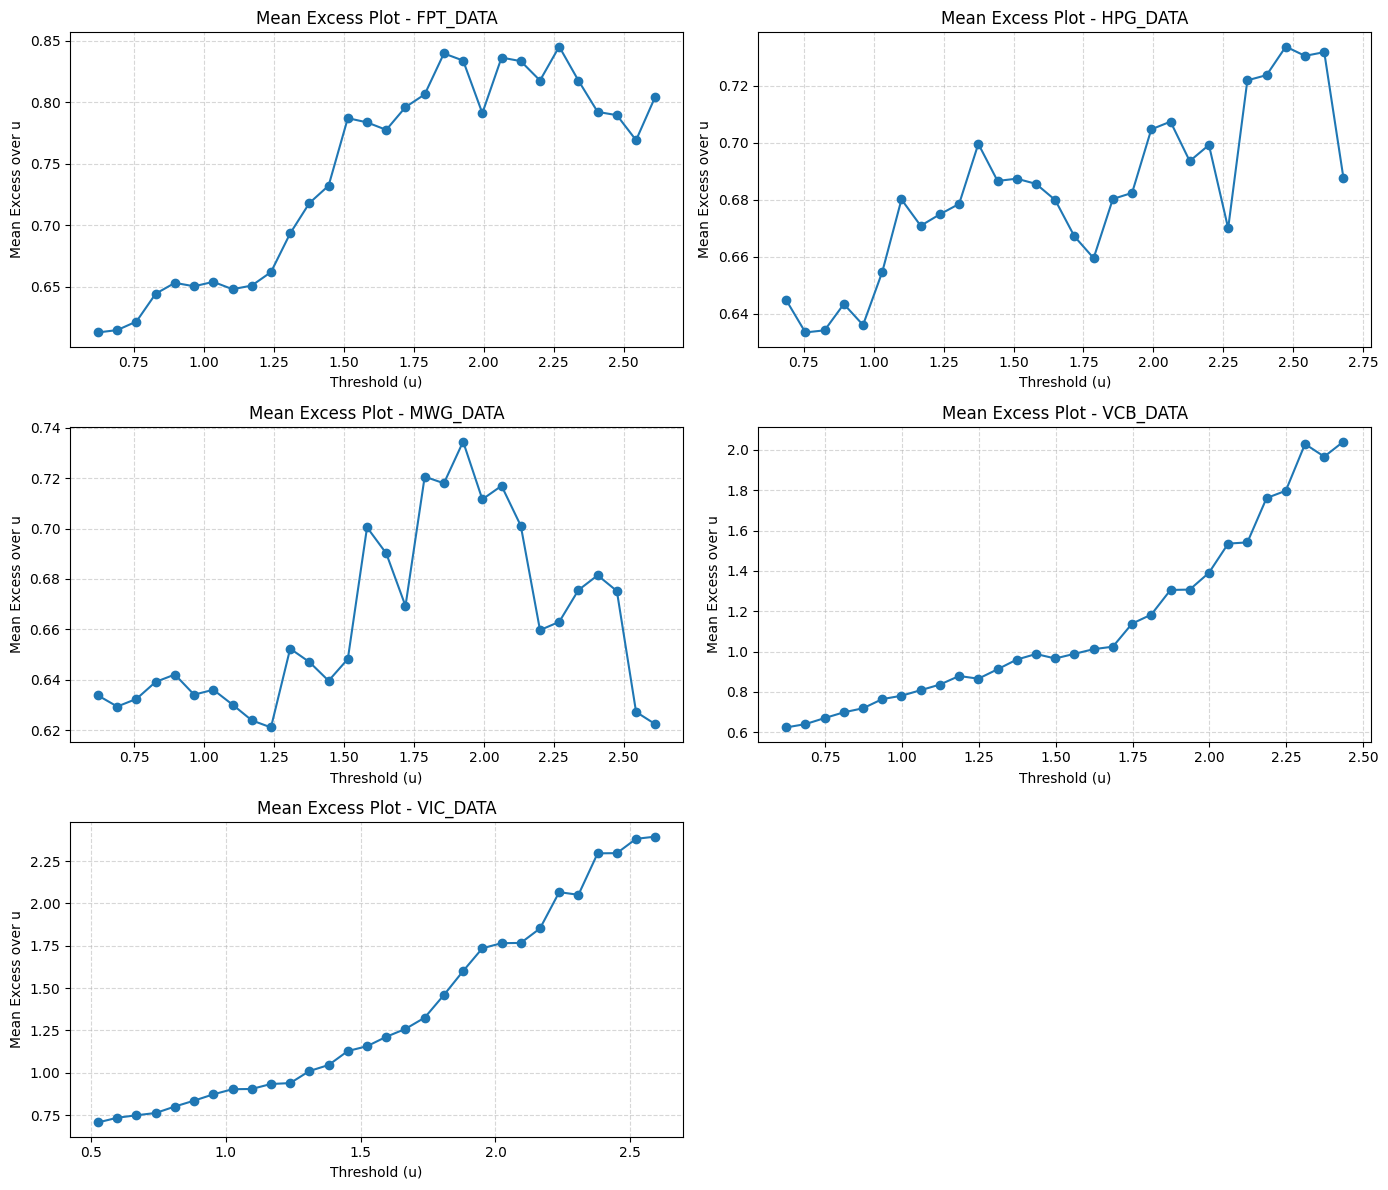

In [17]:
n = len(std_resids)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 4), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids.items()):
    losses = -resid.dropna()
    # Mean Excess Plot
    thresholds = np.linspace(np.percentile(losses, 80), np.percentile(losses, 99), 30)
    mean_excess = []
    for u in thresholds:
        excess = losses[losses > u] - u
        mean_excess.append(excess.mean() if len(excess) > 0 else np.nan)
    axes[i].plot(thresholds, mean_excess, marker='o')
    axes[i].set_title(f"Mean Excess Plot - {ticker}")
    axes[i].set_xlabel("Threshold (u)")
    axes[i].set_ylabel("Mean Excess over u")
    axes[i].grid(True, linestyle='--', alpha=0.5)
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

In [ ]:
# KS-test for each ticker
from scipy.stats import kstest

for ticker, resid in std_resids.items():
    losses = -resid.dropna()
    threshold = evt_results[ticker]['threshold']
    exceedances = losses[losses > threshold] - threshold
    shape = evt_results[ticker]['shape']
    scale = evt_results[ticker]['scale']
    ks_stat, ks_pvalue = kstest(exceedances, 'genpareto', args=(shape, 0, scale))
    print(f"KS-test for GPD fit ({ticker}): statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")
    if ks_pvalue > 0.05:
        print("=> Fail to reject H0: GPD fits the exceedances well.")
    else:
        print("=> Reject H0: GPD does not fit the exceedances well.")

KS-test for GPD fit (FPT_DATA): statistic=0.0526, p-value=0.8176
=> Fail to reject H0: GPD fits the exceedances well.
KS-test for GPD fit (HPG_DATA): statistic=0.0362, p-value=0.9902
=> Fail to reject H0: GPD fits the exceedances well.
KS-test for GPD fit (MWG_DATA): statistic=0.0649, p-value=0.5793
=> Fail to reject H0: GPD fits the exceedances well.
KS-test for GPD fit (VCB_DATA): statistic=0.0935, p-value=0.1649
=> Fail to reject H0: GPD fits the exceedances well.
KS-test for GPD fit (VIC_DATA): statistic=0.0619, p-value=0.6388
=> Fail to reject H0: GPD fits the exceedances well.


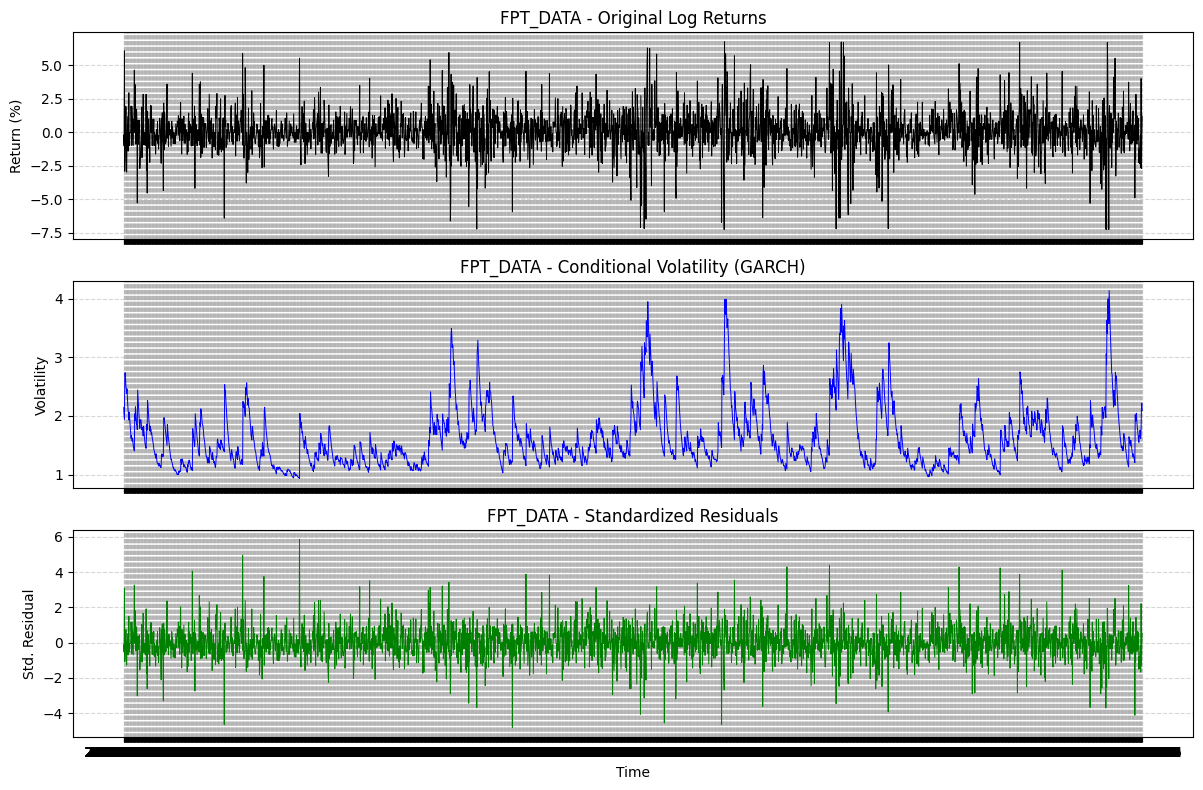

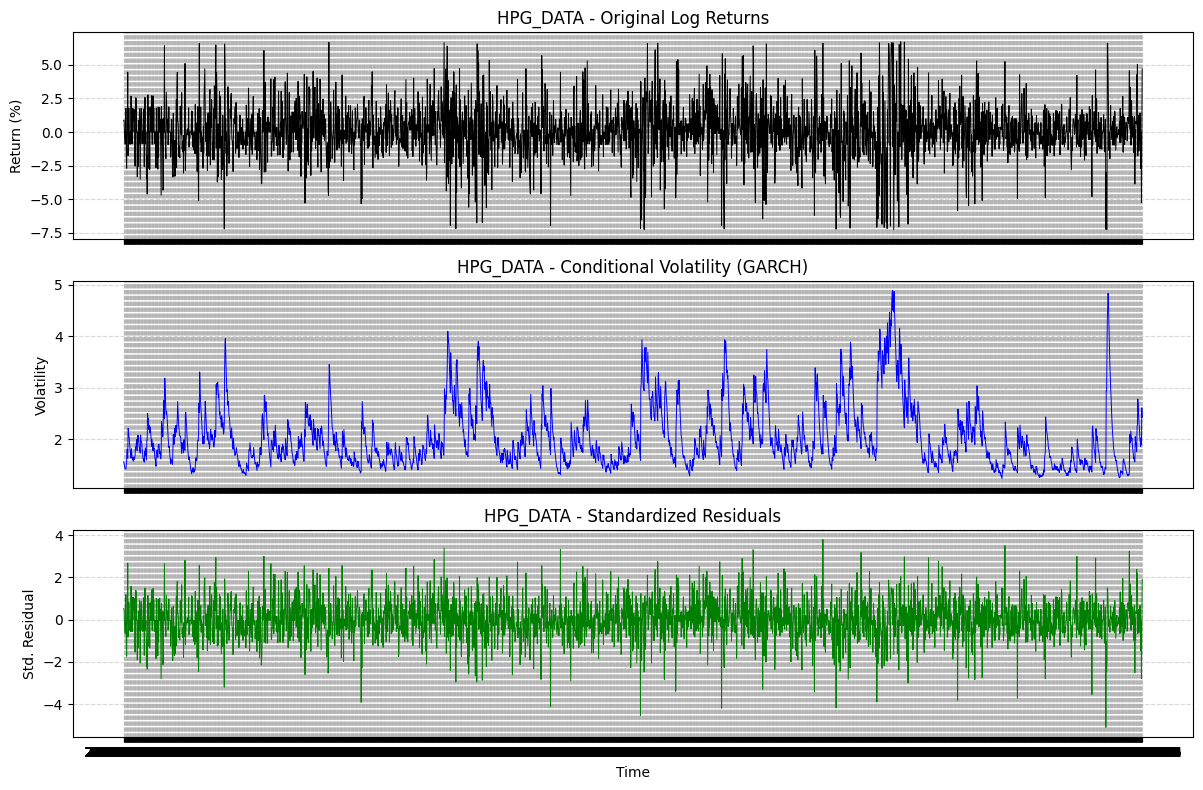

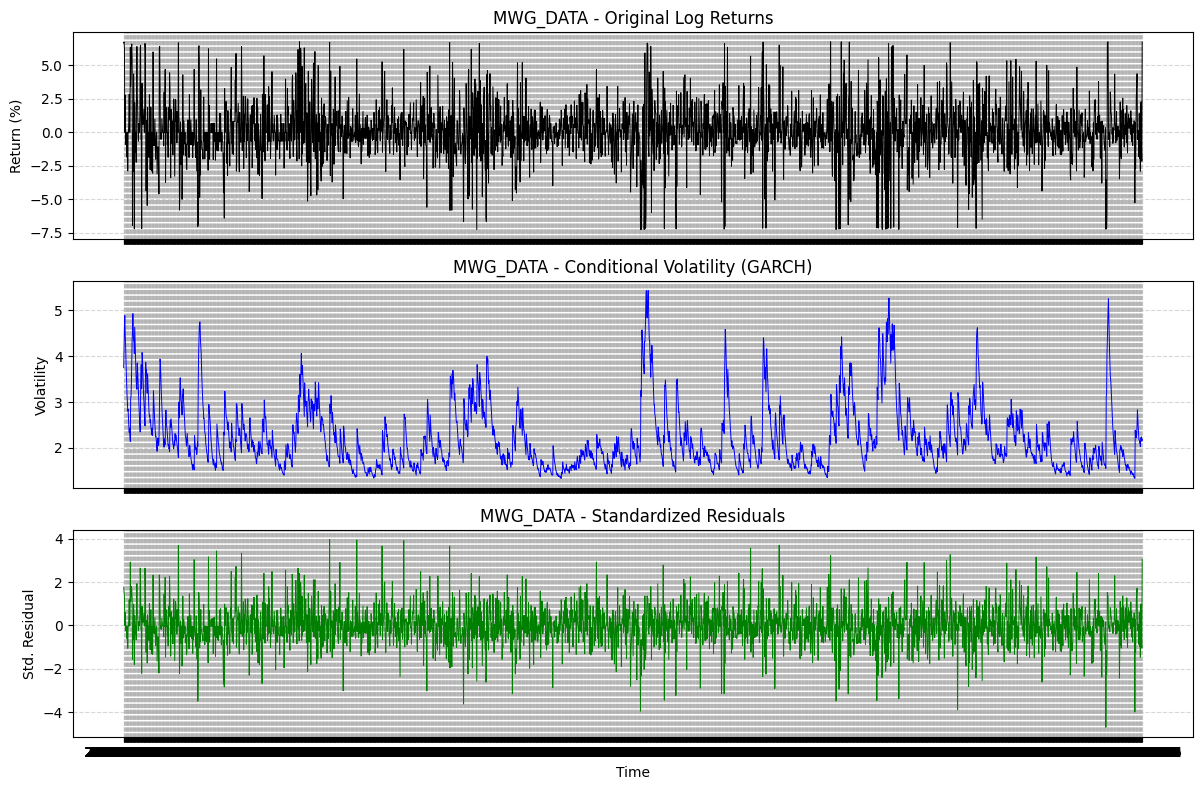

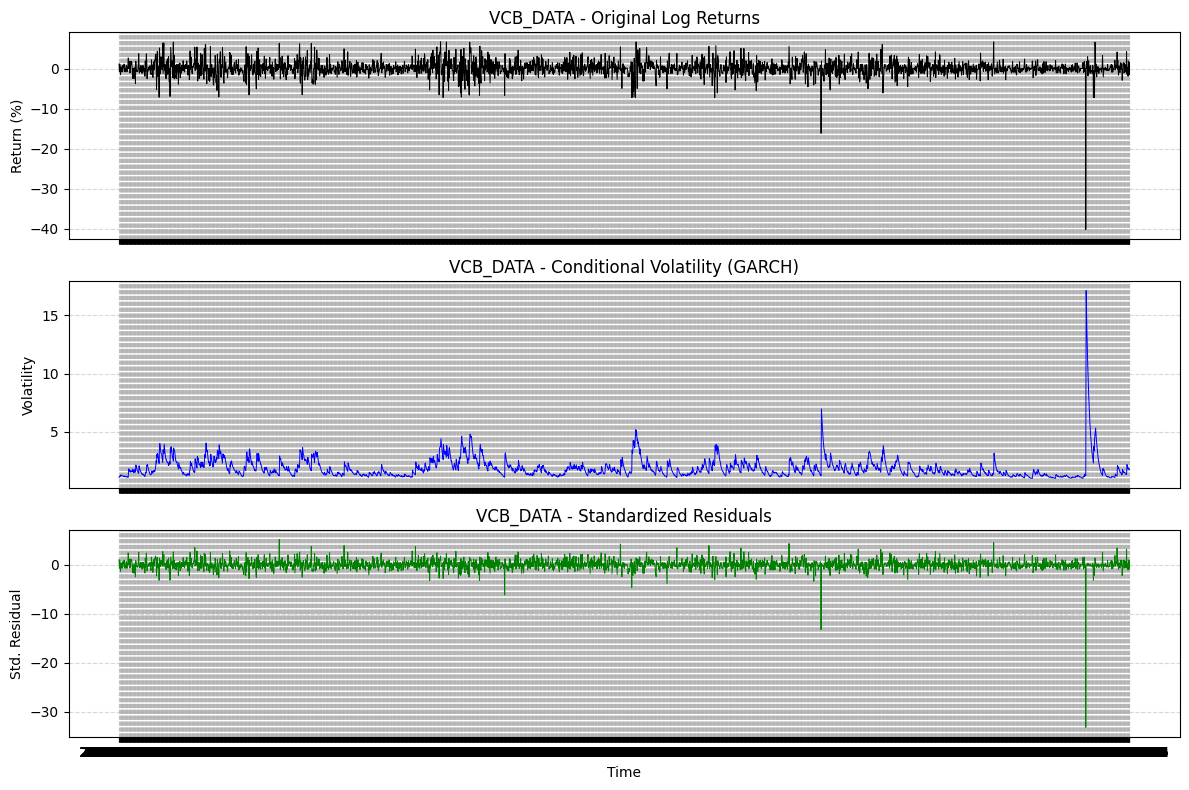

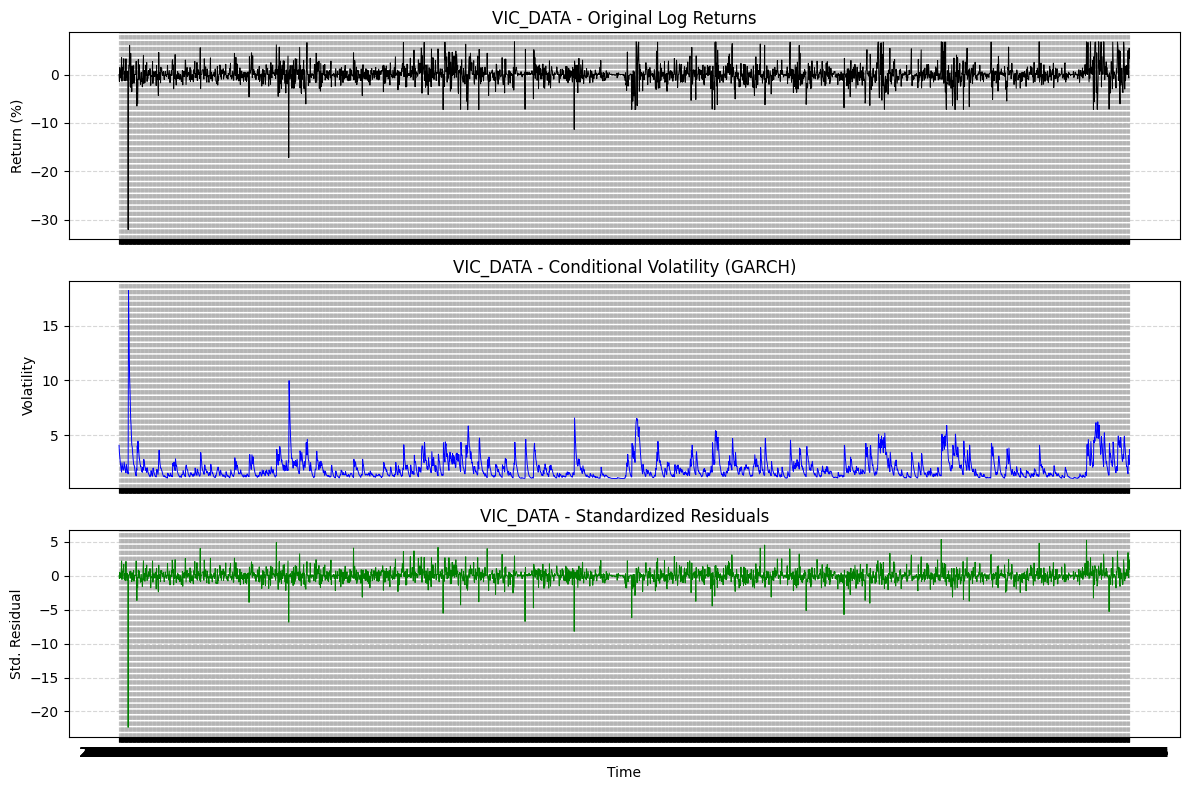

In [30]:
# --- Dashboard plot for each ticker ---
for ticker in std_resids.keys():
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    
    # 1. Original log returns
    axes[0].plot(log_returns_scaled[ticker], color='black', lw=0.7)
    axes[0].set_title(f"{ticker} - Original Log Returns")
    axes[0].set_ylabel("Return (%)")
    axes[0].grid(True, linestyle='--', alpha=0.5)
    
    # 2. Conditional volatility (from GARCH)
    cond_vol = garch_results[ticker].conditional_volatility
    axes[1].plot(cond_vol, color='blue', lw=0.7)
    axes[1].set_title(f"{ticker} - Conditional Volatility (GARCH)")
    axes[1].set_ylabel("Volatility")
    axes[1].grid(True, linestyle='--', alpha=0.5)
    
    # 3. Standardized residuals
    axes[2].plot(std_resids[ticker], color='green', lw=0.7)
    axes[2].set_title(f"{ticker} - Standardized Residuals")
    axes[2].set_ylabel("Std. Residual")
    axes[2].set_xlabel("Time")
    axes[2].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [31]:
# --- Summary table for GARCH and EVT parameters ---
summary = []
for ticker in std_resids.keys():
    garch_param = garch_results[ticker].params
    evt_param = evt_results[ticker]
    summary.append({
        "Ticker": ticker,
        "GARCH_alpha": garch_param.get("alpha[1]", np.nan),
        "GARCH_beta": garch_param.get("beta[1]", np.nan),
        "GARCH_omega": garch_param.get("omega", np.nan),
        "GARCH_nu": garch_param.get("nu", np.nan),
        "EVT_threshold": evt_param.get("threshold", np.nan),
        "EVT_shape": evt_param.get("shape", np.nan),
        "EVT_scale": evt_param.get("scale", np.nan)
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.set_index("Ticker")
display(summary_df)

,GARCH_alpha,GARCH_beta,GARCH_omega,GARCH_nu,EVT_threshold,EVT_shape,EVT_scale
Ticker,,,,,,,
FPT_DATA,0.111047,0.868294,0.096640,3.668975,1.412499,0.094905,0.654200
HPG_DATA,0.127839,0.832622,0.215817,5.036270,1.568912,-0.005887,0.685376
MWG_DATA,0.138947,0.840566,0.227075,3.580470,1.486697,0.016713,0.636377
VCB_DATA,0.180487,0.803711,0.175922,3.545584,1.349298,0.308849,0.572061
VIC_DATA,0.323223,0.676777,0.335515,2.777022,1.362928,0.519020,0.522751
